<a href="https://colab.research.google.com/github/konamilk/hasc-lstm/blob/main/hasc_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!wget http://hasc.jp/hc2012/sampleData/SampleData20121101.zip 

--2021-09-03 00:49:49--  http://hasc.jp/hc2012/sampleData/SampleData20121101.zip
Resolving hasc.jp (hasc.jp)... 157.7.144.5
Connecting to hasc.jp (hasc.jp)|157.7.144.5|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32525712 (31M) [application/zip]
Saving to: ‘SampleData20121101.zip’

SampleData20121101. 100%[===================>]  31.02M  7.67MB/s    in 5.0s    

2021-09-03 00:49:54 (6.20 MB/s) - ‘SampleData20121101.zip’ saved [32525712/32525712]



In [ ]:
!unzip -o SampleData20121101.zip > /dev/null

In [ ]:
INPUT = Path('./HascToolDataPrj/SampleData')

## サンプルプロット


In [ ]:
df_example_stay = pd.read_csv('/content/HascToolDataPrj/SampleData/1_stay/person101/HASC1162.csv', header = None, names = ['time', 'x', 'y', 'z'])
df_example_walk = pd.read_csv('/content/HascToolDataPrj/SampleData/2_walk/person101/HASC2187.csv', header = None, names = ['time', 'x', 'y', 'z'])
df_example_skip = pd.read_csv('/content/HascToolDataPrj/SampleData/4_skip/person103/HASC5293.csv', header = None, names = ['time', 'x', 'y', 'z'])
df_example_jog = pd.read_csv('/content/HascToolDataPrj/SampleData/3_jog/person102/HASC4581.csv', header = None, names = ['time', 'x', 'y', 'z'])
df_example_stay = df_example_stay[300:1300]
df_example_walk = df_example_walk[300:1300]
df_example_skip = df_example_skip[300:1300]
df_example_jog = df_example_jog[300:1300]

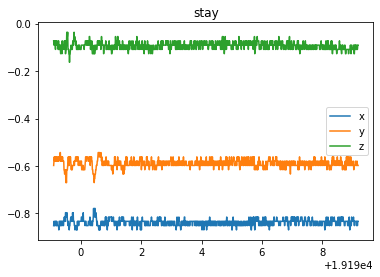

In [ ]:
fig, ax = plt.subplots()

ax.set_title('stay')
ax.plot(df_example_stay.time, df_example_stay.x, label='x')
ax.plot(df_example_stay.time, df_example_stay.y, label='y')
ax.plot(df_example_stay.time, df_example_stay.z, label='z')
ax.legend(loc=0)

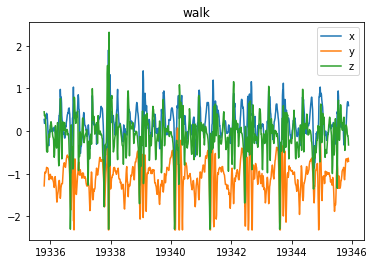

In [ ]:
fig, ax = plt.subplots()

ax.set_title('walk')
ax.plot(df_example_walk.time, df_example_walk.x, label='x')
ax.plot(df_example_walk.time, df_example_walk.y, label='y')
ax.plot(df_example_walk.time, df_example_walk.z, label='z')
ax.legend(loc=0)

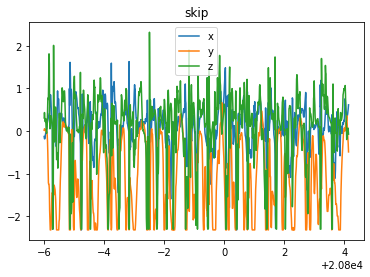

In [ ]:
fig, ax = plt.subplots()

ax.set_title('skip')
ax.plot(df_example_skip.time, df_example_skip.x, label='x')
ax.plot(df_example_skip.time, df_example_skip.y, label='y')
ax.plot(df_example_skip.time, df_example_skip.z, label='z')
ax.legend(loc=0)

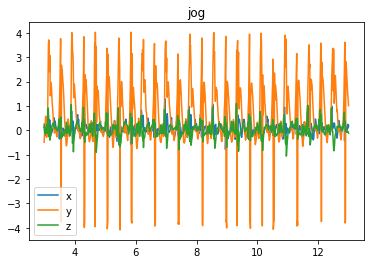

In [ ]:
fig, ax = plt.subplots()

ax.set_title('jog')
ax.plot(df_example_jog.time, df_example_jog.x, label='x')
ax.plot(df_example_jog.time, df_example_jog.y, label='y')
ax.plot(df_example_jog.time, df_example_jog.z, label='z')
ax.legend(loc=0)

# LSTMモデル

In [ ]:
label_names = ['1_stay','2_walk','3_jog','4_skip','5_stUp','6_stDown']

In [ ]:
# min_rows = 1790
# rows = []
# cols = []
SEQ_SIZE = 1000
OFFSET = 300
df = pd.DataFrame()
for index, label in enumerate(label_names):
    for path in glob('./HascToolDataPrj/SampleData/' + label +'/**/*.csv'):
        _df = pd.read_csv(path, header = None, names = ['time', 'x', 'y', 'z'])
        # row, col= df.shape
        # rows.append(row)
        # cols.append(col)
        
        df = df.append(
               pd.DataFrame([[deque(_df['x'][OFFSET : OFFSET +SEQ_SIZE]),
                             deque(_df['y'][OFFSET : OFFSET + SEQ_SIZE]),
                             deque(_df['z'][OFFSET : OFFSET + SEQ_SIZE]),
                             index
                             ]],
                             columns=['x', 'y', 'z', 'label'])
            )


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, hidden_size, seq_size, target_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.seq_size = seq_size
        self.target_size = target_size

        self.lstm = nn.LSTM(input_size=seq_size, hidden_size=hidden_size, batch_first=True, num_layers=1)
        self.fc = nn.Linear(hidden_size, target_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        _, (ht, _) = self.lstm(x)
        out = self.fc(ht.view(-1, self.hidden_size))
        return self.softmax(out)

In [ ]:
class MyDatasets(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        x = self.data.iloc[idx].x
        y = self.data.iloc[idx].y
        z = self.data.iloc[idx].z
        out_data = torch.tensor([x, y, z], dtype=torch.float32)
        out_label = self.data.iloc[idx].label

        return out_data, out_label


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, train_size=0.7)
train_datasets = MyDatasets(train_data)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 20, shuffle = True)

In [ ]:
HIDDEN_SIZE = 50
EPOCHS = 1000

model = LSTMClassifier(hidden_size=HIDDEN_SIZE, seq_size=SEQ_SIZE, target_size=6)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = []
for epoch in range(EPOCHS):
    all_loss = 0
    for x, corrects in train_loader:
        model.zero_grad()
        out = model(x)
        loss = loss_function(out, corrects)
        loss.backward()
        optimizer.step()

        all_loss += loss.item()
    
    losses.append(all_loss)
    if epoch % 10 == 0:
        print("epoch", epoch, "\t" , "loss", all_loss)


epoch 0 	 loss -3.144242286682129
epoch 10 	 loss -3.1914649605751038
epoch 20 	 loss -3.2395273596048355
epoch 30 	 loss -3.2861440032720566
epoch 40 	 loss -3.3355042785406113
epoch 50 	 loss -3.3849714547395706
epoch 60 	 loss -3.435058116912842
epoch 70 	 loss -3.492864742875099
epoch 80 	 loss -3.550383150577545
epoch 90 	 loss -3.613605797290802
epoch 100 	 loss -3.6900487691164017
epoch 110 	 loss -3.768743261694908
epoch 120 	 loss -3.8530379831790924
epoch 130 	 loss -3.955041289329529
epoch 140 	 loss -4.059877932071686
epoch 150 	 loss -4.175637811422348
epoch 160 	 loss -4.297409266233444
epoch 170 	 loss -4.430670499801636
epoch 180 	 loss -4.565083488821983
epoch 190 	 loss -4.710579887032509
epoch 200 	 loss -4.858880415558815
epoch 210 	 loss -5.030428931117058
epoch 220 	 loss -5.178795635700226
epoch 230 	 loss -5.3582943975925446
epoch 240 	 loss -5.542413651943207
epoch 250 	 loss -5.728183016180992
epoch 260 	 loss -5.9235642701387405
epoch 270 	 loss -6.1261104643

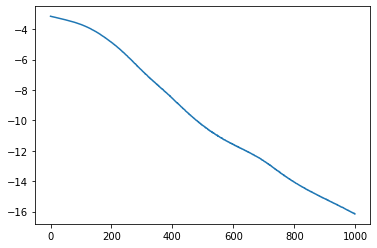

In [ ]:
plt.plot(range(len(losses)), losses)

In [ ]:
test_datasets = MyDatasets(test_data)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 10, shuffle = False, num_workers = 2)

トレインセット対する正答率

In [ ]:
all_count = 0
correct_count = 0

for x, corrects in train_loader:
    preds = model(x).argmax(axis=1)
    all_count += len(preds)

    correct_count += (preds == corrects).sum()

print(correct_count / all_count)

tensor(0.9312)


テストセットに対する正答率

In [ ]:
all_count = 0
correct_count = 0

for x, corrects in test_loader:
    preds = model(x).argmax(axis=1)
    all_count += len(preds)

    correct_count += (preds == corrects).sum()

print(correct_count / all_count)

tensor(0.3519)
